# Import



In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model, utils, initializers, losses, optimizers, Sequential, callbacks, backend
import tensorflow.keras as K

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from scipy.stats import norm
import scipy.stats as measures

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'sans-serif'

In [ ]:
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=28)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('figure', titlesize=28)  # fontsize of the figure title

In [ ]:
from datetime import date

In [ ]:
import math

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Segragation based on moneyness2

In [ ]:
final_df = pd.read_csv('new_model_final_call_df.csv')

In [ ]:
call_df1 = final_df[final_df['moneyness2']<0.95]
call_df2 = final_df[final_df['moneyness2']<0.98]
call_df3 = final_df[final_df['moneyness2']<1.0]
call_df4 = final_df[final_df['moneyness2']<1.02]
call_df5 = final_df[final_df['moneyness2']<1.05]
call_df6 = final_df[1.05<=final_df['moneyness2']]

In [ ]:
call_df2 = call_df2[0.95<=call_df2['moneyness2']]
call_df3 = call_df3[0.98<=call_df3['moneyness2']]
call_df4 = call_df4[1.0<=call_df4['moneyness2']]
call_df5 = call_df5[1.02<=call_df5['moneyness2']]

In [ ]:
len(call_df1) + len(call_df2) + len(call_df3) + len(call_df4) + len(call_df5) + len(call_df6)  

561047

In [ ]:
call_df1.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

# Model

In [ ]:
default_params = {
'LSTM_units': [16, 16, 16, 16],
'LR': 1e-5,
'Dense_units': [100, 100, 100],
'BN_MOMENTUM': 0.9,
'LEAKY_ALPHA': 0.1,
'BIAS_INIT': 'ones',
'KERNEL_INIT': 'glorot_normal',
}

In [ ]:
input_shape = (15)
close_history_shape = (20, 2)

In [ ]:
def build_model(hparams=default_params):
    
    y = Input(shape=input_shape, name='features')
    z = Input(shape=close_history_shape, name='close_history')
    
    x = layers.Bidirectional(layers.LSTM(units=hparams['LSTM_units'][0],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=True))(z)

    for u in hparams['LSTM_units'][1:-1]:
        x = layers.Bidirectional(layers.LSTM(units=u,
                                             bias_initializer=hparams['BIAS_INIT'],
                                             kernel_initializer=hparams['KERNEL_INIT'], 
                                             return_sequences=True))(x)

    x = layers.Bidirectional(layers.LSTM(units=hparams['LSTM_units'][-1],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=False))(x)
    x = layers.concatenate([x, y])

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)

    for u in hparams['Dense_units']:
        x = layers.Dense(units=u, activation="linear")(x)
        x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)
        # x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x) 

    x = layers.Dense(units=1, activation="relu")(x)

    model = Model(inputs=[y, z], outputs=x, name="model_option_price") 

    model.compile(
        loss='mse',
        optimizer=optimizers.Adam(
            learning_rate=hparams['LR']
        )
    )
    print(model.summary())

    return model


In [ ]:
model = build_model()

Model: "model_option_price"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_history (InputLayer)      [(None, 20, 2)]      0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 20, 32)       2432        close_history[0][0]              
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 20, 32)       6272        bidirectional_8[0][0]            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 20, 32)       6272        bidirectional_9[0][0]            
_________________________________________________________________________________

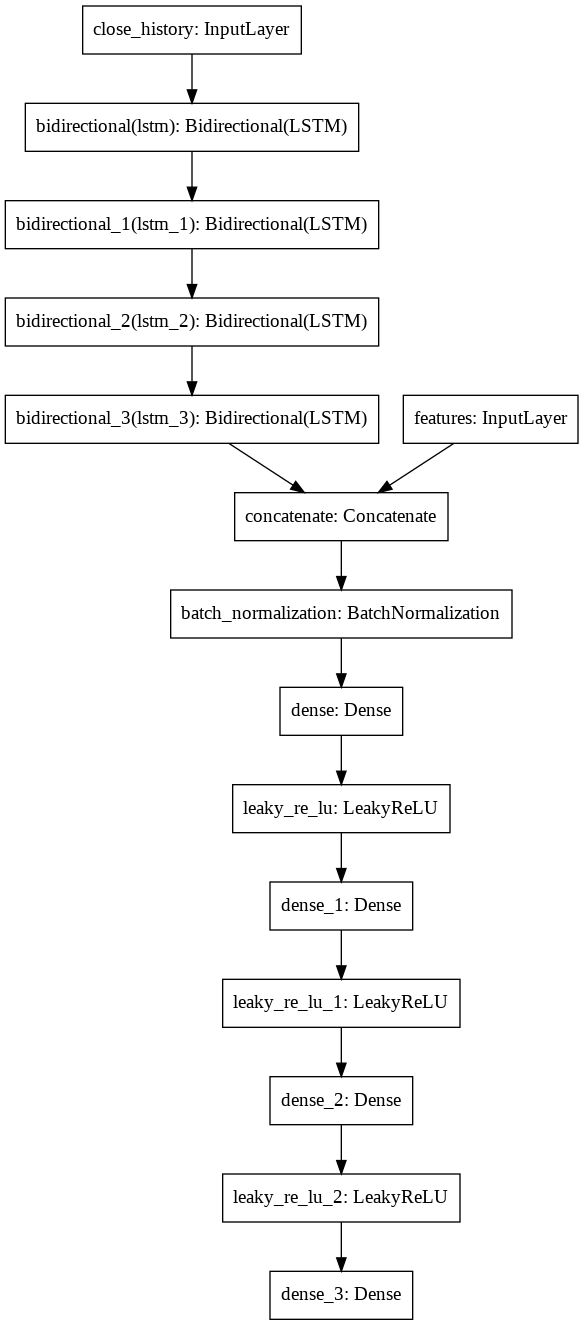

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## 1

In [ ]:
lstm_call = call_df1

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
0,9700,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.850335,0.856191,0.162125,0.565504,1.740855,19.80,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.337460,19.80
1,9750,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.845974,0.851800,0.167266,0.583437,1.796062,17.25,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.336527,17.25
2,9800,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.841658,0.847454,0.172381,0.601279,1.850987,14.95,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.335437,14.95
3,9550,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.863691,0.869639,0.146540,0.511143,1.573510,11.30,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.277892,11.30
4,9600,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.859193,0.865110,0.151762,0.529357,1.629582,9.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.277823,9.60


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((271447, 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(2742, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((2742, 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
training_loss = []
val_loss = []
test_loss = []
test_epochs = []
max_errors = []
mapes = []
rmses = []
ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
263/263 [==============================] - 33s 75ms/step - loss: 0.1405 - val_loss: 0.0948
Epoch 2/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0884 - val_loss: 0.0681
Epoch 3/5
263/263 [==============================] - 16s 62ms/step - loss: 0.0636 - val_loss: 0.0503
Epoch 4/5
263/263 [==============================] - 16s 62ms/step - loss: 0.0477 - val_loss: 0.0375
Epoch 5/5
263/263 [==============================] - 16s 62ms/step - loss: 0.0364 - val_loss: 0.0290
######################################################################
Results at epoch 5
86/86 [==============================] - 2s 20ms/step - loss: 0.0428
{'loss': 0.042807843536138535}
('max error: ', 2034.679917636678)
('mape: ', 551.1148071289062)
('rmse: ', 257.041749405617)
('ccf:', 0.9392517938063548)
######################################################################
Epoch 1/5
263/263 [==============================] - 16s 62ms/step - loss: 0.0276 - val_loss: 0.0226
Epoch 2/5


## 2

In [ ]:
lstm_call = call_df2

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
22,8600,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.959099,0.965704,0.041761,0.145666,0.448420,28.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.128744,28.60
23,8650,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.953555,0.960122,0.047558,0.165887,0.510668,21.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.129486,21.60
24,8700,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.948075,0.954604,0.053322,0.185991,0.572558,15.45,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.128684,15.45
27,8500,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.970382,0.977065,0.030065,0.104869,0.322831,52.45,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.132401,52.45
28,8550,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.964708,0.971351,0.035930,0.125327,0.385810,38.20,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.129098,38.20


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2.shape

(64525, 40)

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((64525, 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(652, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((652, 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 300
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
63/63 [==============================] - 4s 63ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 2/5
63/63 [==============================] - 4s 61ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 3/5
63/63 [==============================] - 4s 61ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/5
63/63 [==============================] - 4s 62ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/5
63/63 [==============================] - 4s 62ms/step - loss: 0.0024 - val_loss: 0.0020
######################################################################
Results at epoch 5
21/21 [==============================] - 0s 19ms/step - loss: 0.0019
{'loss': 0.0019434555433690548}
('max error: ', 849.5557747440826)
('mape: ', 31.85024070739746)
('rmse: ', 86.09589096702729)
('ccf:', 0.9932176454108319)
######################################################################
Epoch 1/5
63/63 [==============================] - 4s 63ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 2/5
63/63 [=========

## 3

In [ ]:
lstm_call = call_df3

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
25,8400,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.981935,0.988697,0.018231,0.063590,0.195756,89.00,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.137847,89.00
26,8450,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.976124,0.982846,0.024165,0.084291,0.259482,68.95,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.134818,68.95
31,8350,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.987814,0.994617,0.012260,0.042765,0.131650,112.65,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.141444,112.65
59,8500,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.970382,0.983344,0.030065,0.075422,0.172578,121.25,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.138110,121.25
63,8400,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.981935,0.995050,0.018231,0.045734,0.104646,167.00,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.142074,167.00


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2.shape

(42460, 40)

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((42460, 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(429, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((429, 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss3 = []
# val_loss3 = []
# test_loss3 = []
# test_epochs = []
# max_errors3 = []
# mapes3 = []
# rmses3 = []
# ccfs3 = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
42/42 [==============================] - 3s 64ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 2/5
42/42 [==============================] - 3s 62ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/5
42/42 [==============================] - 3s 62ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/5
42/42 [==============================] - 3s 62ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/5
42/42 [==============================] - 3s 63ms/step - loss: 0.0015 - val_loss: 0.0013
######################################################################
Results at epoch 5
14/14 [==============================] - 0s 19ms/step - loss: 5.5221e-04
{'loss': 0.0005522091523744166}
('max error: ', 281.7174906692459)
('mape: ', 10.808650970458984)
('rmse: ', 57.865541546221614)
('ccf:', 0.995907573667748)
######################################################################
Epoch 1/5
42/42 [==============================] - 3s 64ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/5
42/42 [====

## 4 

In [ ]:
lstm_call = call_df4

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
29,8250,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.999788,1.006673,0.000212,0.000740,0.002278,115.723985,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.150379,170.40
30,8300,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.993765,1.000609,0.006254,0.021816,0.067159,133.932009,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.144669,138.95
34,8150,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.012055,1.019025,-0.011983,-0.041798,-0.128672,81.207936,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.155614,235.20
35,8200,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.005884,1.012811,-0.005867,-0.020464,-0.062997,97.765961,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.153583,202.10
62,8350,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.987814,1.001009,0.012260,0.030757,0.070377,396.339863,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.305654,404.65


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss4 = []
# val_loss4 = []
# test_loss4 = []
# test_epochs = []
# max_errors4 = []
# mapes4 = []
# rmses4 = []
# ccfs4 = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
41/41 [==============================] - 3s 65ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 2/5
41/41 [==============================] - 3s 63ms/step - loss: 0.0120 - val_loss: 0.0162
Epoch 3/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0104 - val_loss: 0.0157
Epoch 4/5
41/41 [==============================] - 2s 60ms/step - loss: 0.0095 - val_loss: 0.0152
Epoch 5/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0088 - val_loss: 0.0150
######################################################################
Results at epoch 5
14/14 [==============================] - 0s 20ms/step - loss: 0.0129
{'loss': 0.012949995696544647}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


('max error: ', 1004.0520388079135)
('mape: ', 14.045929908752441)
('rmse: ', 176.67789923509108)
('ccf:', 0.9760804034341812)
######################################################################
Epoch 1/5
41/41 [==============================] - 3s 63ms/step - loss: 0.0083 - val_loss: 0.0147
Epoch 2/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0078 - val_loss: 0.0144
Epoch 3/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 4/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0071 - val_loss: 0.0140
Epoch 5/5
41/41 [==============================] - 3s 62ms/step - loss: 0.0068 - val_loss: 0.0138
######################################################################
Results at epoch 10
14/14 [==============================] - 0s 19ms/step - loss: 0.0096
{'loss': 0.00962379202246666}
('max error: ', 917.1896590536612)
('mape: ', 12.280291557312012)
('rmse: ', 147.1674283023421)
('ccf:', 0.982691516967905

## 5

In [ ]:
lstm_call = call_df5

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
32,8050,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.024627,1.031684,-0.024329,-0.084861,-0.261238,51.691888,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.155425,305.00
33,8100,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.018302,1.025315,-0.018137,-0.063263,-0.194750,69.899912,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.161318,273.55
37,7950,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.037516,1.044661,-0.036829,-0.128463,-0.395462,46.525840,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.180717,399.15
38,8000,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,1.031031,1.038132,-0.030560,-0.106594,-0.328140,47.833864,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.166595,350.80
65,8150,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,1.012055,1.025573,-0.011983,-0.030061,-0.068785,352.726034,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.346197,558.40


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(574, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
55/55 [==============================] - 3s 62ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 2/5
55/55 [==============================] - 3s 61ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/5
55/55 [==============================] - 3s 62ms/step - loss: 0.0014 - val_loss: 8.9485e-04
Epoch 4/5
55/55 [==============================] - 3s 62ms/step - loss: 0.0012 - val_loss: 7.7790e-04
Epoch 5/5
55/55 [==============================] - 3s 61ms/step - loss: 0.0011 - val_loss: 7.3422e-04
######################################################################
Results at epoch 5
18/18 [==============================] - 0s 18ms/step - loss: 7.0515e-04
{'loss': 0.0007051534485071898}
('max error: ', 410.40796159299816)
('mape: ', 4.3113532066345215)
('rmse: ', 66.79061191397898)
('ccf:', 0.9955760001815342)
######################################################################
Epoch 1/5
55/55 [==============================] - 3s 63ms/step - loss: 9.5312e-04 - val_loss: 6.3397e-04


## 6

In [ ]:
lstm_call = call_df1

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
0,9700,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.850335,0.856191,0.162125,0.565504,1.740855,19.80,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.337460,19.80
1,9750,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.845974,0.851800,0.167266,0.583437,1.796062,17.25,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.336527,17.25
2,9800,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.841658,0.847454,0.172381,0.601279,1.850987,14.95,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.335437,14.95
3,9550,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.863691,0.869639,0.146540,0.511143,1.573510,11.30,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.277892,11.30
4,9600,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.859193,0.865110,0.151762,0.529357,1.629582,9.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.277823,9.60


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(2742, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_call(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0445 - val_loss: 0.0195
Epoch 2/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0157 - val_loss: 0.0103
Epoch 3/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 4/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 5/5
263/263 [==============================] - 16s 61ms/step - loss: 0.0048 - val_loss: 0.0036
######################################################################
Results at epoch 5
86/86 [==============================] - 2s 19ms/step - loss: 0.0051
{'loss': 0.005059037357568741}
('max error: ', 604.4931411623572)
('mape: ', 138.98834228515625)
('rmse: ', 74.32036793399068)
('ccf:', 0.9938188390991052)
######################################################################
Epoch 1/5
263/263 [==============================] - 16s 62ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 2/

# Graphs

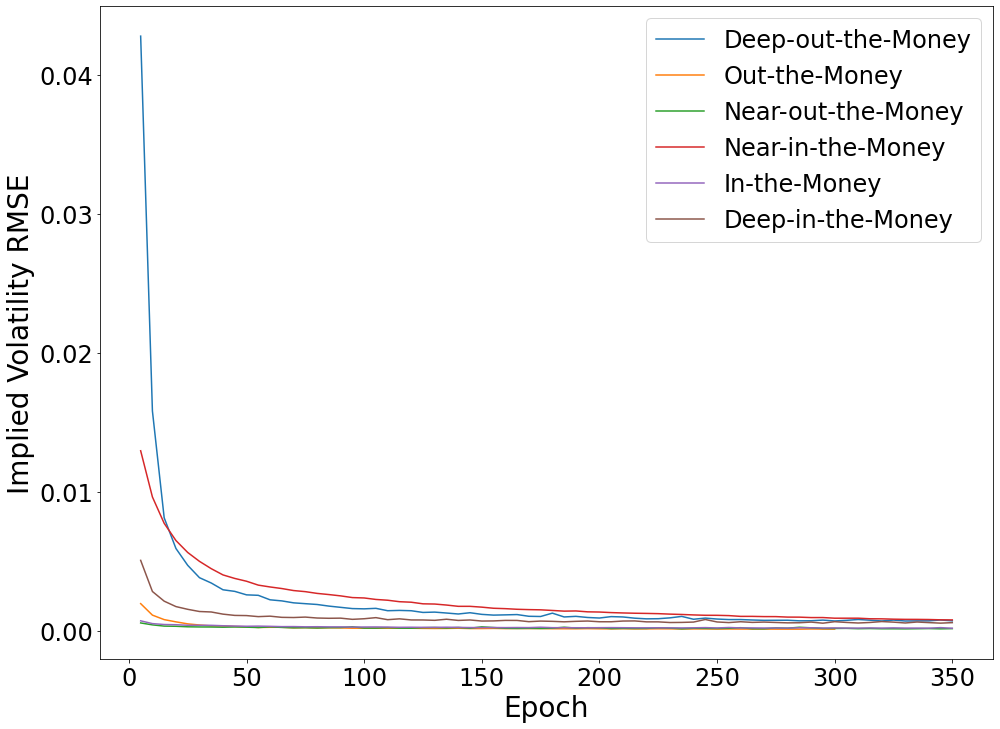

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:70], test_loss[:70], label='Deep-out-the-Money')
plt.plot(test_epochs[70:130], test_loss[70:130], label='Out-the-Money')
plt.plot(test_epochs[130:200], test_loss[130:200], label='Near-out-the-Money')
plt.plot(test_epochs[200:270], test_loss[200:270], label='Near-in-the-Money')
plt.plot(test_epochs[270:340], test_loss[270:340], label='In-the-Money')
plt.plot(test_epochs[340:], test_loss[340:], label='Deep-in-the-Money')
# plt.plot(test_epochs, mapes)
plt.xlabel('Epoch')
plt.ylabel('Implied Volatility RMSE')
plt.legend()
plt.savefig('test_loss_exp3.png')
plt.show()

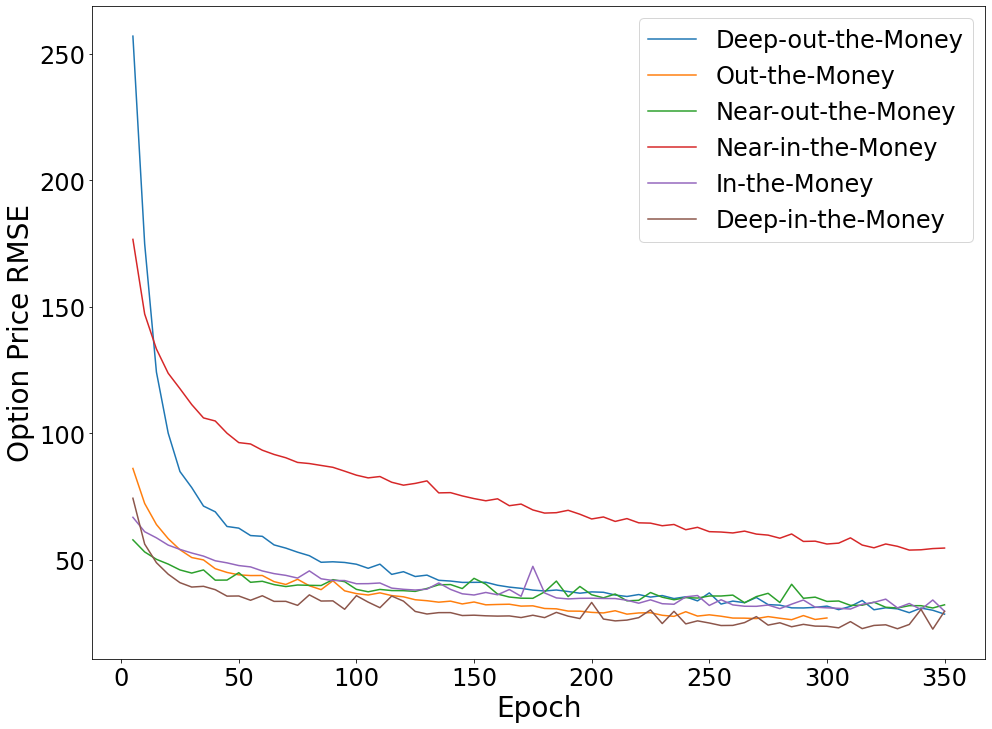

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:70], rmses[:70], label='Deep-out-the-Money')
plt.plot(test_epochs[70:130], rmses[70:130], label='Out-the-Money')
plt.plot(test_epochs[130:200], rmses[130:200], label='Near-out-the-Money')
plt.plot(test_epochs[200:270], rmses[200:270], label='Near-in-the-Money')
plt.plot(test_epochs[270:340], rmses[270:340], label='In-the-Money')
plt.plot(test_epochs[340:], rmses[340:], label='Deep-in-the-Money')
plt.xlabel('Epoch')
plt.ylabel('Option Price RMSE')
plt.legend()
plt.savefig('rmse_exp3.png')
plt.show()

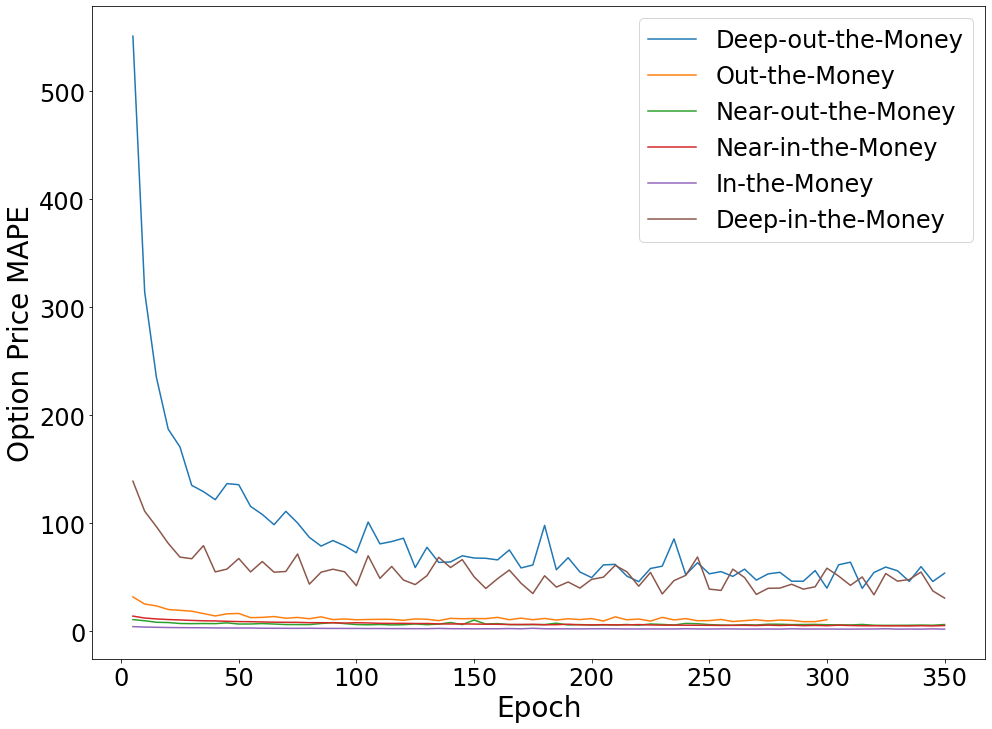

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:70], mapes[:70], label='Deep-out-the-Money')
plt.plot(test_epochs[70:130], mapes[70:130], label='Out-the-Money')
plt.plot(test_epochs[130:200], mapes[130:200], label='Near-out-the-Money')
plt.plot(test_epochs[200:270], mapes[200:270], label='Near-in-the-Money')
plt.plot(test_epochs[270:340], mapes[270:340], label='In-the-Money')
plt.plot(test_epochs[340:], mapes[340:], label='Deep-in-the-Money')
# plt.plot(test_epochs, mapes)
plt.xlabel('Epoch')
plt.ylabel('Option Price MAPE')
plt.legend()
plt.savefig('mape_exp3.png')
plt.show()

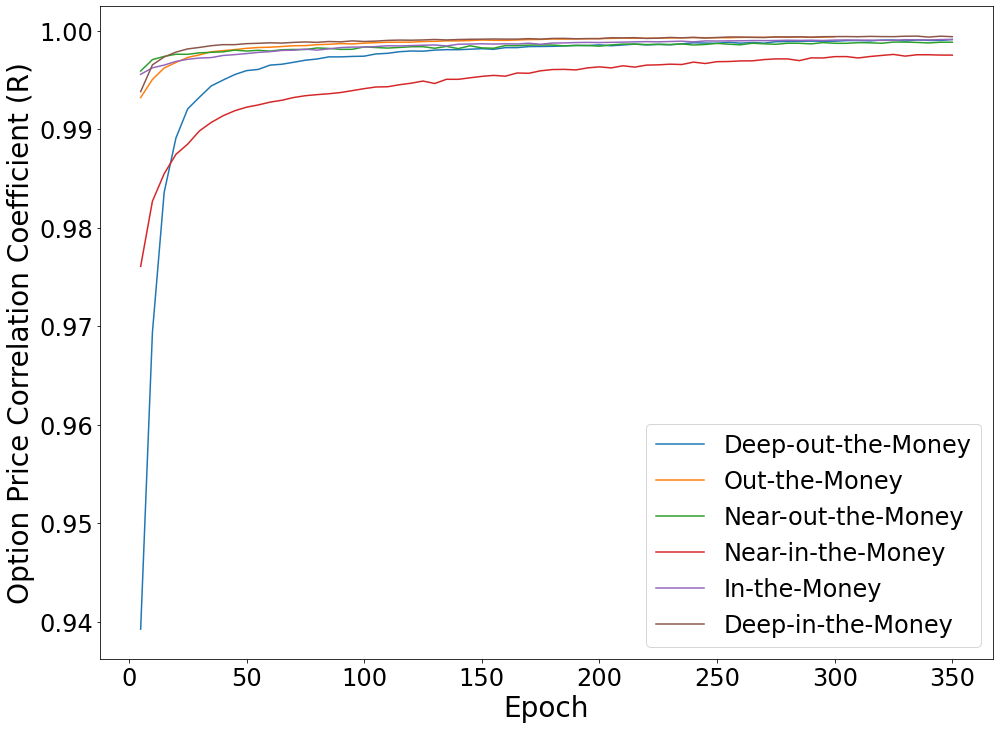

In [ ]:
plt.figure(figsize=(16, 12))
# plt.plot(test_epochs, ccfs)
plt.plot(test_epochs[:70], ccfs[:70], label='Deep-out-the-Money')
plt.plot(test_epochs[70:130], ccfs[70:130], label='Out-the-Money')
plt.plot(test_epochs[130:200], ccfs[130:200], label='Near-out-the-Money')
plt.plot(test_epochs[200:270], ccfs[200:270], label='Near-in-the-Money')
plt.plot(test_epochs[270:340], ccfs[270:340], label='In-the-Money')
plt.plot(test_epochs[340:], ccfs[340:], label='Deep-in-the-Money')
plt.xlabel('Epoch')
plt.ylabel('Option Price Correlation Coefficient (R)')
plt.legend()
plt.savefig('ccf_exp3.png')
plt.show()

In [ ]:
print(training_loss)

[0.12192749232053757, 0.08139321208000183, 0.059142351150512695, 0.04450468346476555, 0.03459499403834343, 0.027648640796542168, 0.022218061611056328, 0.017892001196742058, 0.01483139768242836, 0.012437799945473671, 0.010553870350122452, 0.009267880581319332, 0.008257883600890636, 0.007525873836129904, 0.0069458093494176865, 0.006399870850145817, 0.00602710573002696, 0.005636994261294603, 0.005410438869148493, 0.005180837586522102, 0.004924569744616747, 0.0047199903056025505, 0.004571589641273022, 0.004411328583955765, 0.004337012302130461, 0.004154609050601721, 0.004085113760083914, 0.0039269644767045975, 0.003868379630148411, 0.0038866600953042507, 0.0037767007015645504, 0.0036258415784686804, 0.003621471580117941, 0.0035730653908103704, 0.003461136482656002, 0.003400800283998251, 0.0033013918437063694, 0.003292713314294815, 0.0032379410695284605, 0.0031967174727469683, 0.003198650199919939, 0.0031244675628840923, 0.0031616792548447847, 0.0030553224496543407, 0.0029659054707735777, 0

In [ ]:
print(val_loss)

[0.09481954574584961, 0.06811127811670303, 0.050292570143938065, 0.03750893101096153, 0.02897392027080059, 0.022626647725701332, 0.017696917057037354, 0.01400399673730135, 0.011367620900273323, 0.009570330381393433, 0.008089326322078705, 0.007132309954613447, 0.00620197132229805, 0.00581511901691556, 0.005230745766311884, 0.005025993566960096, 0.004735592752695084, 0.004492145963013172, 0.004208794329315424, 0.004125296603888273, 0.003979618661105633, 0.0037696100771427155, 0.0036616597790271044, 0.003532197093591094, 0.0034497790038585663, 0.003367776982486248, 0.0032624949235469103, 0.003149660537019372, 0.003068150021135807, 0.0030491601210087538, 0.0030430061742663383, 0.002896512160077691, 0.0028735031373798847, 0.0028433611150830984, 0.002821083180606365, 0.0027527748607099056, 0.002639882965013385, 0.0026599487755447626, 0.002590643474832177, 0.0025338917039334774, 0.0025299377739429474, 0.002521329326555133, 0.0025179379153996706, 0.0024179485626518726, 0.0024091857485473156, 0

In [ ]:
print(test_loss)

[0.042807843536138535, 0.015814270824193954, 0.008121884427964687, 0.005912523251026869, 0.00470117200165987, 0.003811137517914176, 0.0034277813974767923, 0.0029399453196674585, 0.0028251996263861656, 0.002574602607637644, 0.0025413513649255037, 0.0022176834754645824, 0.0021398868411779404, 0.0019995819311589003, 0.001939315814524889, 0.0018811278278008103, 0.0017650388181209564, 0.0016755007673054934, 0.0015861111460253596, 0.0015674849273636937, 0.0016029969556257129, 0.0014322848292067647, 0.0014542584540322423, 0.0014311393024399877, 0.0013087382540106773, 0.0013318617129698396, 0.0012662493390962481, 0.0011964007280766964, 0.0012873205123469234, 0.0011694959830492735, 0.0011155526153743267, 0.001133943791501224, 0.0011550051858648658, 0.0010317566338926554, 0.001016272814013064, 0.0012572325067594647, 0.0009835385717451572, 0.00102648523170501, 0.0009452305384911597, 0.0009057981078512967, 0.0010078221093863249, 0.0009824767475947738, 0.0008948552422225475, 0.000847595336381346, 0

In [ ]:
print(rmses)

[257.041749405617, 174.87946741970597, 124.19688486808958, 100.06355402318069, 84.87509780001729, 78.54283266154843, 71.22537609039878, 68.96042371579875, 63.15827943918952, 62.50206832515125, 59.56924845361174, 59.26379800439936, 55.868685849890454, 54.60340185501838, 52.991085814325885, 51.601036735587975, 49.00414274180679, 49.19346324636918, 48.92713711319875, 48.229518199762786, 46.623724953242686, 48.25881355708509, 44.21091334046875, 45.27329661863326, 43.37096410438382, 43.92324376424671, 41.873462250216576, 41.57767580084293, 41.04324219030689, 41.06555145863212, 41.10550717028757, 39.916511381374185, 39.18516832925677, 38.69643317451477, 37.994989968353885, 37.65859853931519, 38.034923366661495, 37.437255450995934, 36.76754072250753, 37.295911107674556, 37.133077956393876, 36.05278045471147, 35.476353466406856, 36.243033746048184, 35.2334880708769, 35.84164185714188, 34.649488252105726, 35.35339687920296, 33.7338068791902, 36.8898242183312, 32.47059028410844, 33.6548862304940

In [ ]:
print(mapes)

[551.1148071289062, 314.2981872558594, 235.0345001220703, 187.2075653076172, 170.72422790527344, 135.153076171875, 129.28257751464844, 121.88677978515625, 136.71646118164062, 135.73687744140625, 115.69817352294922, 108.19318389892578, 98.71728515625, 111.0729751586914, 100.30303955078125, 86.96121978759766, 78.89891815185547, 84.01713562011719, 79.21145629882812, 72.68247985839844, 101.15994262695312, 80.94287109375, 83.0942153930664, 86.20915985107422, 59.02577209472656, 77.79479217529297, 63.77619171142578, 64.22089385986328, 69.91999053955078, 67.86750793457031, 67.58637237548828, 66.11198425292969, 75.3292236328125, 58.67826461791992, 61.38254165649414, 98.07058715820312, 56.989845275878906, 68.16621398925781, 54.93509292602539, 49.696189880371094, 61.448726654052734, 61.99712371826172, 51.06629180908203, 45.96649932861328, 58.15239334106445, 60.308834075927734, 85.55143737792969, 52.40739059448242, 63.459835052490234, 53.224761962890625, 55.24875259399414, 50.8475341796875, 57.554

In [ ]:
print(ccfs)

[0.9392517938063548, 0.9693729056100446, 0.9835980033075831, 0.9891138573472209, 0.9920692905921329, 0.9932532746945723, 0.9943942703143086, 0.9949879329504058, 0.9955488074017602, 0.9959490010155168, 0.9960729222892014, 0.9965072268118668, 0.9965973548674245, 0.9967947478936501, 0.9970061852441973, 0.9971287957746826, 0.9973459675661867, 0.9973445854037409, 0.9973903250991238, 0.9974156536379104, 0.9976416215987816, 0.9977076140586792, 0.9978696037697289, 0.997942223458799, 0.9979217163648543, 0.9980305865213646, 0.9980766918435464, 0.9980721621737355, 0.9981219401625372, 0.9981772497673129, 0.9981129498537726, 0.9982832862185178, 0.9982832013379404, 0.9983906933244753, 0.9983991911705608, 0.9984157781031784, 0.9984594658967412, 0.9985093906551848, 0.9984958104426112, 0.9985661464255039, 0.9984733902544548, 0.998551017202286, 0.9986418103715011, 0.9985568320611689, 0.9986146214775471, 0.9985695689577713, 0.9986662061062188, 0.9987752028023212, 0.9987449123468656, 0.9987286835031988, 0

In [ ]:
len(test_loss)

410